In [21]:
import pandas as pd
import os
from tqdm.auto import tqdm
from huggingface_hub import InferenceClient

In [49]:
data = pd.read_csv("results/test_query_results.csv")
print(data.shape)
data.head()

(80, 4)


,query,keyword,expected_recipe,response
0,I want a kosher recipe,kosher,low carb chicken salad,"Based on the provided context, here is a koshe..."
1,"I have orange peel, what can I make that's low...",low-carb,pork chops in orange sauce,Based on the ingredients you have (orange peel...
2,I want a quick kosher recipe,kosher,vegetarian cassoulet,"Based on the provided context, here is a quick..."
3,I need cheap meal ideas,inexpensive,hawaiian pizzas,"Based on the provided context, here are a coup..."
4,"I'm trying to be healthy, show me recipes with...",healthy,creamy souper rice,"Based on the provided context, here is a recip..."


In [ ]:
from huggingface_hub import InferenceClient
import os

# Retrieve the API token
api_token = os.getenv("API_TOKEN")

client = InferenceClient(
    model="meta-llama/Llama-3.1-8B-Instruct",
    token=api_token
)

In [46]:
import pandas as pd
import json
import re

results = []

for idx, row in data.iterrows():
    user_query = row["query"]
    model_response = row["response"]

    try:
        completion = client.chat.completions.create(
            model="meta-llama/Llama-3.1-8B-Instruct",
            messages=[
                {
                    "role": "user",
                    "content": f"""
You are an impartial evaluation model acting as a judge for a recipe
recommendation system called CookCompass.

Your task is to evaluate the SYSTEM RESPONSE based on the USER QUERY
and score it on the criteria listed below.

Do NOT rewrite, improve, or explain the recipe.
Only evaluate it.

--------------------------------------------------
USER QUERY:
{user_query}

--------------------------------------------------
SYSTEM RESPONSE:
{model_response}

--------------------------------------------------
EVALUATION CRITERIA:

1. RELEVANCE (0-10):
How well does the response satisfy the user's query and constraints?

2. HEALTHINESS (0-10):
How healthy is the recipe in a general nutritional sense?

3. TASTE (0-10):
How appealing and plausible is the recipe?

--------------------------------------------------
OUTPUT FORMAT (STRICT JSON):

{{
  "relevance": <integer 0-10>,
  "healthiness": <integer 0-10>,
  "taste": <integer 0-10>
}}
"""
                }
            ],
        )

        # Extract content
        response_content = completion.choices[0].message.content

        # Try to extract JSON from the response
        try:
            scores = json.loads(response_content)
        except json.JSONDecodeError:
            # If that fails, try to extract JSON object from the string
            json_match = re.search(r'\{[^{}]*\}', response_content)
            if json_match:
                scores = json.loads(json_match.group())
            else:
                raise ValueError(f"Could not extract valid JSON from response: {response_content}")

        results.append({
            "user_query": user_query,
            "model_response": model_response,
            "relevance": scores.get("relevance", None),
            "healthiness": scores.get("healthiness", None),
            "taste": scores.get("taste", None)
        })

    except json.JSONDecodeError as e:
        print(f"Row {idx}: JSON parsing error - {e}")
        results.append({
            "user_query": user_query,
            "model_response": model_response,
            "relevance": None,
            "healthiness": None,
            "taste": None,
            "error": f"JSON parsing failed: {str(e)}"
        })
    except Exception as e:
        print(f"Row {idx}: Unexpected error - {e}")
        results.append({
            "user_query": user_query,
            "model_response": model_response,
            "relevance": None,
            "healthiness": None,
            "taste": None,
            "error": str(e)
        })

results_df = pd.DataFrame(results)
results_df

,user_query,model_response,relevance,healthiness,taste
0,I want a kosher recipe,"Based on the provided context, here is a koshe...",8,9,8
1,"I have orange peel, what can I make that's low...",Based on the ingredients you have (orange peel...,8,6,8
2,I want a quick kosher recipe,"Based on the provided context, here is a quick...",8,9,7
3,I need cheap meal ideas,"Based on the provided context, here are a coup...",8,6,8
4,"I'm trying to be healthy, show me recipes with...","Based on the provided context, here is a recip...",8,9,7
...,...,...,...,...,...
75,I want a inexpensive recipe using fresh ground...,"Based on the provided context, here is a recip...",8,6,8
76,What's a good 15-minutes-or-less meal?,"Based on the provided context, here's a quick ...",9,5,7
77,Can you suggest gluten-free food?,Certainly! Here's a gluten-free recipe for **G...,8,9,9
78,I need quick meal ideas,"Based on the provided CONTEXT, here are two qu...",8,5,7


In [48]:
if not os.path.exists("results/results_eval.csv"):
    results_df.to_csv("results/results_eval.csv", index=False)
else:
    results_df = pd.read_csv('results/results_eval.csv')

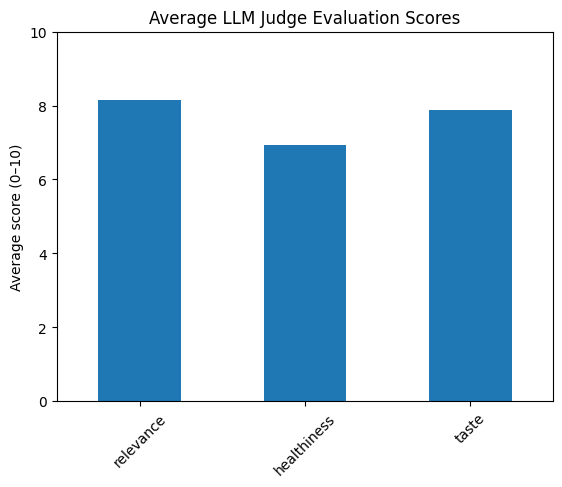

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

# Compute averages
avg_scores = results_df[["relevance", "healthiness", "taste"]].mean()

# Plot
plt.figure()
avg_scores.plot(kind="bar")
plt.ylabel("Average score (0–10)")
plt.title("Average LLM Judge Evaluation Scores")
plt.xticks(rotation=45)
plt.ylim(0, 10)
plt.show()
plt.savefig('Evaluation.png')
